In [138]:
library('igraph')
library('dplyr')

<h2>Question 6</h2>

In [2]:
movement_graph <- read.table('../uber_data/movement_edgelist.txt')

In [3]:
g <- graph_from_data_frame(movement_graph, directed=FALSE)

In [4]:
E(g)$weight=as.numeric(movement_graph[,3])

In [5]:
is.connected(g)
writeLines(paste("Number of edges: ", ecount(g)))
writeLines(paste("Number of vertices: ", vcount(g)))
writeLines(paste("Diameter: ", diameter(g)))
#plot(g, vertex.label=NA, vertex.size=3)

[1] FALSE

Number of edges:  311812
Number of vertices:  1887
Diameter:  11911.84


In [6]:
dg <- decompose.graph(g)      
gcc_index <- which.max(sapply(dg,vcount))
gcc <- dg[[gcc_index]] 
clusters <- components(gcc)
#print(dim(groups(clusters)))
writeLines(paste("Number of edges: ", ecount(gcc)))
writeLines(paste("Number of vertices: ", vcount(gcc)))
writeLines(paste("Diameter of GCC: ", diameter(gcc)))

Number of edges:  311802
Number of vertices:  1880
Diameter of GCC:  11911.84


In [7]:
geo_data <- read.table('../uber_data/geo_data.csv', sep=',', header=TRUE)

In [8]:
#print(which(name_sectors_colors$Symbol == 'ZTS'))
print(geo_data[which(geo_data$movement_id == '1'),1])

[1] Sargent Creek, San Ardo
2704 Levels: 0 12th East Street, Pittsburg ...


In [9]:
v = 1
which(V(gcc)$name == v)

integer(0)

In [10]:
v = 6
print(v)
gcc <- set_vertex_attr(gcc, "location", index=which(V(gcc)$name == v), as.character(geo_data[which(geo_data$movement_id == v), 2]))
gcc <- set_vertex_attr(gcc, "display_name", index=which(V(gcc)$name == v), as.character(geo_data[which(geo_data$movement_id == v), 1]))

[1] 6


In [11]:
geo_data[which(geo_data$movement_id == v), 1]

[1] 100 Carlsbad Circle, Vacaville
2704 Levels: 0 12th East Street, Pittsburg ...

In [12]:
vertex_attr(gcc, index=1)

$name
[1] "6"

$location
[1] "[-121.94843241   38.36665327]"

$display_name
[1] "100 Carlsbad Circle, Vacaville"

In [13]:
for (v in V(gcc)$name) {
    gcc <- set_vertex_attr(gcc, "location", index=which(V(gcc)$name == v), 
                           as.character(geo_data[which(geo_data$movement_id == v), 2]))
    gcc <- set_vertex_attr(gcc, "display_name", index=which(V(gcc)$name == v), 
                           as.character(geo_data[which(geo_data$movement_id == v), 1]))
}

In [14]:
all_info <- cbind(vertex_attr(gcc)$name, vertex_attr(gcc)$location, vertex_attr(gcc)$display_name)

<h2>Question 7</h2>

In [15]:
g_mst <- mst(gcc, algorithm="prim")

In [16]:
is.connected(g_mst)
writeLines(paste("Number of edges: ", ecount(g_mst)))
writeLines(paste("Number of vertices: ", vcount(g_mst)))
writeLines(paste("Diameter: ", diameter(g_mst)))
#plot(g, vertex.label=NA, vertex.size=3)

[1] TRUE

Number of edges:  1879
Number of vertices:  1880
Diameter:  45542.45


In [17]:
E(g_mst)

+ 1879/1879 edges from 460670d (vertex names):
 [1] 7  --25  20 --79  43 --101 55 --102 57 --102 64 --104 62 --105 13 --111
 [9] 138--8   93 --150 123--153 43 --191 63 --219 198--223 178--224 230--115
[17] 39 --253 141--254 252--274 171--282 216--290 74 --300 143--301 78 --302
[25] 303--304 251--309 210--311 274--312 286--323 221--328 199--331 329--331
[33] 41 --334 91 --338 315--338 309--349 6  --366 275--370 253--372 369--372
[41] 325--382 333--389 175--396 371--397 270--400 40 --401 242--403 89 --420
[49] 30 --422 291--423 59 --435 134--437 80 --445 113--445 288--447 58 --456
[57] 283--456 98 --458 321--458 167--466 333--468 290--470 393--470 103--472
[65] 104--472 218--473 382--473 385--477 225--480 485--486 416--488 188--505
[73] 516--517 339--530 394--530 299--532 434--536 113--537 233--543 542--543
+ ... omitted several edges

In [18]:
vertex_attr(g_mst, index=which(V(g_mst)$name == 7))

$name
[1] "7"

$location
[1] "[-121.99610391   38.32584685]"

$display_name
[1] "Unnamed Road, Vacaville"

In [19]:
vertex_attr(g_mst, index=which(V(g_mst)$name == 25))

$name
[1] "25"

$location
[1] "[-121.9796351    38.34320795]"

$display_name
[1] "400 Bowline Drive, Vacaville"

<h2>Question 8</h2>

In [20]:
#graph_triangles = cliques(g, min=3,max=3)
graph_triangles = as.vector(triangles(gcc))

In [21]:
length(graph_triangles)/3

[1] 31678905

In [22]:
set.seed(0)
sample_ids = sample(length(graph_triangles)/3, 1000)

In [23]:
get_id <- function(x) {
    return (which(V(gcc)$name == x$name))
}

In [24]:
check_triangular_inequality <- function(w1, w2, w3) {
    if (((w1 + w2) > w3) & ((w1 + w3) > w2) & ((w3 + w2) > w1)) {
        return (1)
    } else {
        return (0)
    }
}

In [25]:
triads = c()
for (s in sample_ids) {
    #print(i)
    i = s*3 + 1
    u = (graph_triangles[[i]])
    v = (graph_triangles[[i+1]])
    w = (graph_triangles[[i+2]])
    
    e1 <- get.edge.ids(gcc, vp=c(u,v))
    e2 <- get.edge.ids(gcc, vp=c(v,w))
    e3 <- get.edge.ids(gcc, vp=c(u,w))
    #ei <- get.edge.ids(gcc, vp=lapply(c(u, v, v, w, u, w), get_name))
    w1 = edge_attr(gcc, "weight", index=e1)
    w2 = edge_attr(gcc, "weight", index=e2)
    w3 = edge_attr(gcc, "weight", index=e3)
    #print(c(u,v,w))
    triads = c(triads, check_triangular_inequality(w1, w2, w3))
}

In [26]:
tri_eq = sum(triads)/length(triads)

In [27]:
length(triads)

[1] 1000

In [28]:
writeLines(paste("Percentage of triangles satisfying triangular inequality: ", tri_eq))

Percentage of triangles satisfying triangular inequality:  0.929


<h2>Question 9</h2>

In [29]:
mst_vertices <- as.vector(V(g_mst))

In [30]:
V(g_mst)

+ 1880/1880 vertices, named, from 460670d:
   [1] 6    7    9    11   13   17   20   21   23   24   25   27   28   30  
  [15] 31   38   39   40   41   42   43   44   46   47   48   55   56   57  
  [29] 58   59   60   61   62   63   64   65   66   69   73   74   75   76  
  [43] 77   78   79   80   81   82   83   86   87   88   89   90   91   92  
  [57] 93   94   96   97   98   99   100  101  102  103  104  105  107  108 
  [71] 109  111  113  116  117  118  119  123  125  126  127  128  131  132 
  [85] 133  134  136  137  138  141  142  143  146  150  151  152  153  154 
  [99] 155  156  157  158  159  160  165  167  168  169  170  171  172  173 
 [113] 174  175  176  178  179  181  182  184  186  187  188  191  193  194 
 [127] 195  196  198  199  204  206  207  208  209  210  211  212  215  216 
+ ... omitted several vertices

In [50]:
mst_vertices[[1]]

[1] 1

In [116]:
set.seed(0)
root_node <- sample(mst_vertices, 1)
#root_node <- mst_vertices[[1]]
root_node

[1] 1686

In [117]:
preorder <- dfs(g_mst, root_node)

In [118]:
preorder

$root
[1] 1685

$neimode
[1] "out"

$order
+ 1880/1880 vertices, named, from 460670d:
   [1] 2458 1955 2504 1456 410  1452 1451 409  1450 1732 677  541  1438 676 
  [15] 1739 2451 311  210  1273 858  659  2318 1265 652  1271 1705 965  78  
  [29] 302  2343 2629 1780 2466 1944 44   2643 209  2465 1730 1449 2497 2673
  [43] 1781 82   1704 2316 651  208  1698 1281 1706 2442 908  1299 2443 1703
  [57] 650  206  2315 629  2622 1629 2319 1272 653  1639 2498 1783 665  2320
  [71] 675  1951 2625 1630 1646 1707 1702 2317 1282 207  1700 1699 648  2496
  [85] 1696 443  647  2601 646  1300 2321 1648 1278 1280 1682 113  445  80  
  [99] 867  2313 1276 536  434  643  9    1674 644  1691 1245 963  2340 1692
 [113] 1279 1694 2308 1695 1246 20   79   905  1688 1244 642  212  1686 1689
 [127] 1690 1257 165  641  452  866  1687 533  2460 906  1247 21   964  2606
+ ... omitted several vertices

$order.out
NULL

$father
NULL

$dist
NULL


In [119]:
order <- c(as.vector(preorder$order))

In [120]:
edge_ids <- c()

In [121]:
get_shortest_distance <- function(gcc, order) {
    u = order[[1]]
    v = order[[length(order)]]
    cost = c()
    #print(length(unlist(order)))
    if (length(unlist(order)) == 2) {
        e = get.edge.ids(gcc, vp=c(u,v))
        w = edge_attr(gcc, "weight", index=e)
        cost = c(cost, w)
        edge_ids <<- c(edge_ids, e)
    }
    else {
        f = order[[2]]
        e = get.edge.ids(gcc, vp=c(u,f))
        w = edge_attr(gcc, "weight", index=e)
        if (length(w) == 0) {
            w = get_shortest_distance(gcc, vpath, u, f)
        }
        cost = c(cost, w)
        edge_ids <<- c(edge_ids, e)
        for (i in seq(from=2, to=length(order)-1, by=1)) {
            f = order[[i]]
            s = order[[i+1]]
            e = get.edge.ids(gcc, vp=c(f,s))
            w = edge_attr(gcc, "weight", index=e)
            if (length(w) == 0) {
                w = get_shortest_distance(gcc, vpath, f, s)
            }
            cost = c(cost, w) 
            edge_ids <<- c(edge_ids, e)
        }    
    }
    #print(edge_ids)
    return (sum(cost))
}

In [122]:
get_TSP_cost <- function(g_mst, order, root, gcc) {
    cost = c()
    for (i in seq(from=1, to=length(order)-1, by=1)) {
        #print(i)
        u = order[[i]]
        v = order[[i+1]]
       
        e = get.edge.ids(g_mst, vp=c(u,v))
        w = edge_attr(g_mst, "weight", index=e)
        
        if (length(w) == 0) {
            #print(c(u, v))
            vpath = as.vector(get.shortest.paths(gcc, u, v)$vpath[[1]])
            w = get_shortest_distance(gcc, vpath)
        }
        cost = c(cost, w)
        edge_ids <<- c(edge_ids, e)
    }
    u = order[[length(order)]]
    v = order[[root]]
    e = get.edge.ids(g_mst, vp=c(u,v))
    w = edge_attr(g_mst, "weight", index=e)
    if (length(w) == 0) {
        #print(c(u, v))
        vpath = as.vector(get.shortest.paths(gcc, u, v)$vpath[[1]])
        w = get_shortest_distance(gcc, vpath)
    }
    cost = c(cost, w)
    edge_ids <<- c(edge_ids, e)
    return (sum(cost))
}

In [123]:
cost = (get_TSP_cost(g_mst, order, root_node, gcc))

In [124]:
cost

[1] 437929.1

In [125]:
length(edge_ids)

[1] 2809

In [126]:
optimal_cost = sum(edge_attr(g_mst, "weight"))
optimal_cost

[1] 279408.2

In [127]:
cost/optimal_cost

[1] 1.567345

<h2>Question 10</h2>

In [152]:
edges = edge_ids[edge_ids > 0]
length(edges)

[1] 2316

In [170]:
trajectory <- subgraph.edges(gcc, edges)

In [171]:
is.connected(trajectory)
writeLines(paste("Number of edges: ", ecount(trajectory)))
writeLines(paste("Number of vertices: ", vcount(trajectory)))
writeLines(paste("Diameter: ", diameter(trajectory)))

[1] FALSE

Number of edges:  2286
Number of vertices:  1182
Diameter:  17614.095


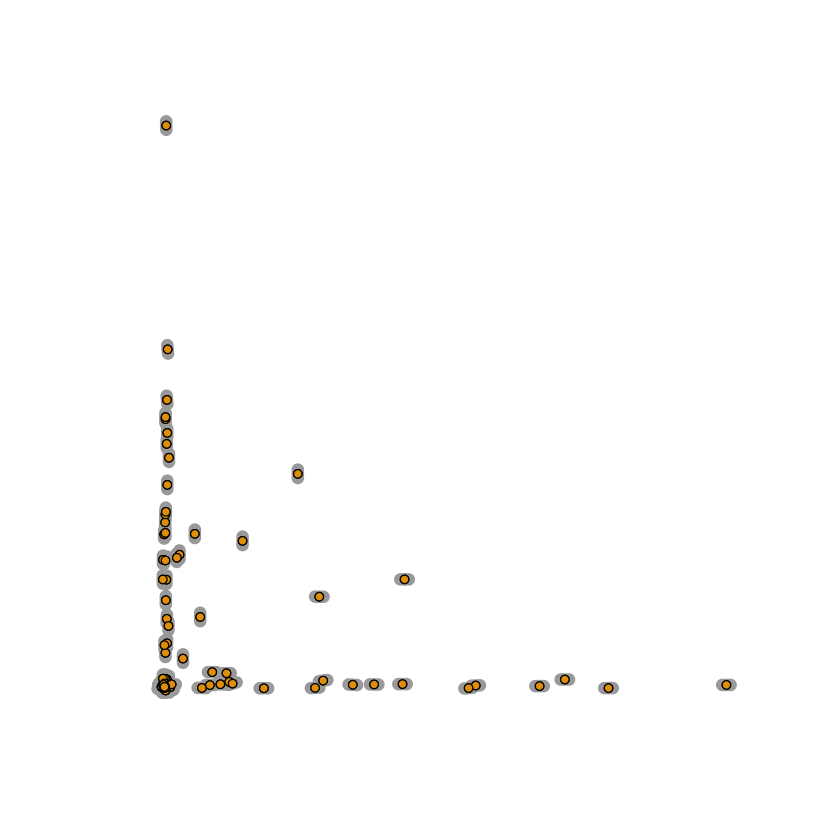

In [175]:
plot(trajectory, vertex.label=NA, vertex.size=3, edge.width=10, layout=layout.fruchterman.reingold)

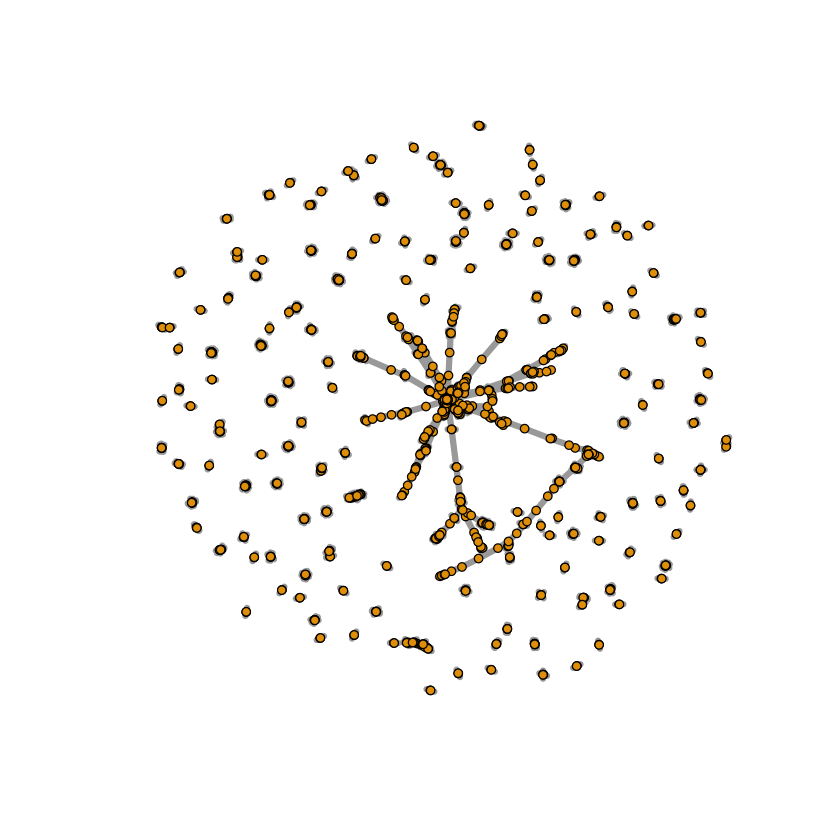

In [178]:
plot(trajectory, vertex.label=NA, vertex.size=3, edge.width=5)